In [1]:
import pandas as pd
import numpy as np
np.random.seed(42) # for development (todo: remove)

dataset_df = pd.DataFrame.from_csv('transformed_df.csv')
dataset_df = dataset_df.loc[1:,:]  # remove first zero column (todo: do this in prep module)
dataset_df.head()

,market-price,trade-volume,median-confirmation-time,hash-rate,transaction-fees-usd,n-unique-addresses,n-transactions,n-transactions-excluding-popular,y
1,0.015803,0.424290,0.133799,-0.082271,-0.008613,0.057326,0.039425,0.050552,0.0
2,-0.000046,0.222325,0.000341,-0.049052,0.058132,0.165571,0.166915,0.193245,0.0
3,-0.005983,-0.084664,0.009061,0.035952,-0.079365,0.105493,0.117706,0.145358,0.0
4,-0.007918,-0.387700,0.016443,-0.105713,0.290439,0.030396,0.038097,0.056164,1.0
5,-0.004852,0.095258,0.078221,-0.060060,0.053765,0.049041,0.034057,0.023677,1.0



***PARTITION DATA INTO TEST AND VALIDATION FOR SINGLE POINT AND 2D INPUTS***

In [2]:
# SPLIT DATA INTO TRAINING AND TEST SET
dataset = dataset_df.copy(deep=True)
dataset = dataset.values
# split into train and test sets
train_size = int(len(dataset) * 0.8)
test_size = len(dataset) - train_size
train, test = dataset[0:train_size,:], dataset[train_size:len(dataset),:]
print(train.shape)
print(test.shape)

(1581, 9)
(396, 9)


In [3]:
# convert an array of values into a dataset matrix
def create_dataset(dataset, look_back=1):
    dataX, dataY = [], []
    for i in range(len(dataset)-look_back-1):
        a = dataset[i:(i+look_back), 0:8]
        a = a.flatten() # flatten to 1D
#         print(a)
#         print(a.shape)
        dataX.append(a)
        dataY.append(dataset[i + look_back, 8])
    return np.array(dataX), np.array(dataY)

In [4]:
look_back = 1
trainX, trainY = create_dataset(train, look_back)
testX, testY = create_dataset(test, look_back)

print('trainX: ', trainX.shape)
print('trainY', trainY.shape)
print('testX', testX.shape)
print('testY', testY.shape)

trainX:  (1579, 8)
trainY (1579,)
testX (394, 8)
testY (394,)


In [5]:
look_back = 30
trainXX, trainYY = create_dataset(train, look_back)
testXX, testYY = create_dataset(test, look_back)

print('trainXX:', trainXX.shape)
print('trainYY:', trainYY.shape)
print('testXX:', testXX.shape)
print('testYY:', testYY.shape)

trainXX: (1550, 240)
trainYY: (1550,)
testXX: (365, 240)
testYY: (365,)


***KERAS MODELS***

In [6]:
from keras.models import Sequential
from keras.layers import Dense

# FOR PRINTING ALL WEIGHTS 
def get_weights(model):
    for layer in model.layers:
        weights = layer.get_weights() # list of numpy arrays
    return weights

Using TensorFlow backend.


Model_1 for single data points

In [7]:
# CRREATE MODEL_1
model_1 = Sequential()
model_1.add(Dense(12, input_dim=8, activation='relu'))
model_1.add(Dense(8, activation='relu'))
model_1.add(Dense(8, activation='relu'))
model_1.add(Dense(1, activation='sigmoid'))

# Compile model
model_1.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

Model_2 for multiple data points

In [8]:
# CREATE MODEL_2
model_2 = Sequential()
model_2.add(Dense(12, input_dim=look_back*8, activation='relu'))
model_2.add(Dense(8, activation='relu')) # 4 layers with 2 hidden layers is enough to model any non-linearity
model_2.add(Dense(8, activation='relu'))
model_2.add(Dense(1, activation='sigmoid'))

# Compile model
model_2.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

# sample_weight_mode: If you need to do timestep-wise sample weighting (2D weights), set this to "temporal".
# None defaults to sample-wise weights (1D). If the model has multiple outputs, you can use a different 
# sample_weight_mode on each output by passing a dictionary or a list of modes.

# from https://keras.io/models/model/

In [9]:
# BENCHMARK MODEL
from keras.initializers import Ones

model_benchmark = Sequential()
model_benchmark.add(Dense(12, input_dim=8, activation='sigmoid', kernel_initializer='ones',))
model_benchmark.add(Dense(1, activation='sigmoid', kernel_initializer='ones'))
model_benchmark.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

w = get_weights(model_benchmark)

# testing to see predictions of benchmark model
# index = 0
# for x in model_benchmark.predict(trainX):
#     print(x, trainY[index])
#     index+=1

**TRAINING**

In [10]:
# FIT MODEL_1
history_1 = model_1.fit(trainX, trainY, epochs=100, batch_size=200, validation_data=(testX, testY), shuffle=False)

Train on 1579 samples, validate on 394 samples
Epoch 1/100
1579/1579 [==============================] - 0s - loss: 0.6901 - acc: 0.5345 - val_loss: 0.6771 - val_acc: 0.6193
Epoch 2/100
1579/1579 [==============================] - 0s - loss: 0.6896 - acc: 0.5301 - val_loss: 0.6774 - val_acc: 0.6193
Epoch 3/100
1579/1579 [==============================] - 0s - loss: 0.6892 - acc: 0.5370 - val_loss: 0.6777 - val_acc: 0.6193
Epoch 4/100
1579/1579 [==============================] - 0s - loss: 0.6886 - acc: 0.5478 - val_loss: 0.6781 - val_acc: 0.6168
Epoch 5/100
1579/1579 [==============================] - 0s - loss: 0.6882 - acc: 0.5484 - val_loss: 0.6783 - val_acc: 0.6066
Epoch 6/100
1579/1579 [==============================] - 0s - loss: 0.6878 - acc: 0.5522 - val_loss: 0.6783 - val_acc: 0.5888
Epoch 7/100
1579/1579 [==============================] - 0s - loss: 0.6876 - acc: 0.5503 - val_loss: 0.6781 - val_acc: 0.5888
Epoch 8/100
1579/1579 [==============================] - 0s - loss: 0.6

1579/1579 [==============================] - 0s - loss: 0.6762 - acc: 0.5693 - val_loss: 0.6748 - val_acc: 0.5761
Epoch 65/100
1579/1579 [==============================] - 0s - loss: 0.6760 - acc: 0.5706 - val_loss: 0.6749 - val_acc: 0.5736
Epoch 66/100
1579/1579 [==============================] - 0s - loss: 0.6757 - acc: 0.5706 - val_loss: 0.6750 - val_acc: 0.5761
Epoch 67/100
1579/1579 [==============================] - 0s - loss: 0.6754 - acc: 0.5731 - val_loss: 0.6750 - val_acc: 0.5787
Epoch 68/100
1579/1579 [==============================] - 0s - loss: 0.6752 - acc: 0.5744 - val_loss: 0.6751 - val_acc: 0.5787
Epoch 69/100
1579/1579 [==============================] - 0s - loss: 0.6749 - acc: 0.5744 - val_loss: 0.6751 - val_acc: 0.5736
Epoch 70/100
1579/1579 [==============================] - 0s - loss: 0.6747 - acc: 0.5757 - val_loss: 0.6752 - val_acc: 0.5711
Epoch 71/100
1579/1579 [==============================] - 0s - loss: 0.6744 - acc: 0.5763 - val_loss: 0.6753 - val_acc: 0.57

In [11]:
# FIT MODEL_2
history_2 = model_2.fit(trainXX, trainYY, epochs=150, batch_size=200, validation_data=(testXX, testYY), shuffle=False)

Train on 1550 samples, validate on 365 samples
Epoch 1/150
1550/1550 [==============================] - 0s - loss: 0.6914 - acc: 0.5265 - val_loss: 0.6776 - val_acc: 0.5945
Epoch 2/150
1550/1550 [==============================] - 0s - loss: 0.6867 - acc: 0.5342 - val_loss: 0.6772 - val_acc: 0.5890
Epoch 3/150
1550/1550 [==============================] - 0s - loss: 0.6841 - acc: 0.5490 - val_loss: 0.6765 - val_acc: 0.5726
Epoch 4/150
1550/1550 [==============================] - 0s - loss: 0.6818 - acc: 0.5516 - val_loss: 0.6765 - val_acc: 0.5589
Epoch 5/150
1550/1550 [==============================] - 0s - loss: 0.6797 - acc: 0.5606 - val_loss: 0.6755 - val_acc: 0.5726
Epoch 6/150
1550/1550 [==============================] - 0s - loss: 0.6785 - acc: 0.5665 - val_loss: 0.6757 - val_acc: 0.5644
Epoch 7/150
1550/1550 [==============================] - 0s - loss: 0.6762 - acc: 0.5690 - val_loss: 0.6761 - val_acc: 0.5534
Epoch 8/150
1550/1550 [==============================] - 0s - loss: 0.6

1550/1550 [==============================] - 0s - loss: 0.4270 - acc: 0.8045 - val_loss: 0.9005 - val_acc: 0.5068
Epoch 66/150
1550/1550 [==============================] - 0s - loss: 0.4099 - acc: 0.8419 - val_loss: 0.8825 - val_acc: 0.5425
Epoch 67/150
1550/1550 [==============================] - 0s - loss: 0.4055 - acc: 0.8290 - val_loss: 0.9010 - val_acc: 0.5151
Epoch 68/150
1550/1550 [==============================] - 0s - loss: 0.3927 - acc: 0.8542 - val_loss: 0.8980 - val_acc: 0.5425
Epoch 69/150
1550/1550 [==============================] - 0s - loss: 0.3900 - acc: 0.8432 - val_loss: 0.9123 - val_acc: 0.5123
Epoch 70/150
1550/1550 [==============================] - 0s - loss: 0.3816 - acc: 0.8555 - val_loss: 0.9134 - val_acc: 0.5507
Epoch 71/150
1550/1550 [==============================] - ETA: 0s - loss: 0.3091 - acc: 0.920 - 0s - loss: 0.3805 - acc: 0.8439 - val_loss: 0.9318 - val_acc: 0.5123
Epoch 72/150
1550/1550 [==============================] - 0s - loss: 0.3740 - acc: 0.8

1550/1550 [==============================] - 0s - loss: 0.1790 - acc: 0.9477 - val_loss: 1.4300 - val_acc: 0.5342
Epoch 130/150
1550/1550 [==============================] - 0s - loss: 0.1746 - acc: 0.9555 - val_loss: 1.4526 - val_acc: 0.5315
Epoch 131/150
1550/1550 [==============================] - 0s - loss: 0.1746 - acc: 0.9490 - val_loss: 1.4556 - val_acc: 0.5370
Epoch 132/150
1550/1550 [==============================] - 0s - loss: 0.1718 - acc: 0.9581 - val_loss: 1.4783 - val_acc: 0.5288
Epoch 133/150
1550/1550 [==============================] - 0s - loss: 0.1753 - acc: 0.9471 - val_loss: 1.4760 - val_acc: 0.5370
Epoch 134/150
1550/1550 [==============================] - 0s - loss: 0.1730 - acc: 0.9529 - val_loss: 1.5001 - val_acc: 0.5315
Epoch 135/150
1550/1550 [==============================] - 0s - loss: 0.1835 - acc: 0.9406 - val_loss: 1.5001 - val_acc: 0.5288
Epoch 136/150
1550/1550 [==============================] - 0s - loss: 0.1795 - acc: 0.9503 - val_loss: 1.5090 - val_ac

In [12]:
# history = model_benchmark.fit(trainX, trainY, epochs=100, batch_size=200, validation_data=(testX, testY), verbose=2, shuffle=False)

***MODEL EVALUATION***

In [13]:
import matplotlib.pyplot as plt

def display_training_history(history):
    # summarize history for accuracy
    plt.figure(figsize=(12, 4), dpi=120)
    plt.subplot(1, 2, 1)
    plt.plot(history.history['acc'])
    plt.plot(history.history['val_acc'])
    plt.title('model accuracy')
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper left')
    
    # summarize history for loss
    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper left')
    plt.show()
    
def display_results(model, trainX, trainY, testX, testY):
    trainScore = model.evaluate(trainX, trainY, verbose=0)
    print('Training Score:')
    print('accuracy:\t' + str(trainScore[1]*100) + ' %', 'loss: \t\t' + str(trainScore[0]), sep='\n')
    testScore = model.evaluate(testX, testY, verbose=0)
    print()
    print('Test Score:')
    print('accuracy:\t' + str(testScore[1]*100) + ' %', 'loss: \t\t' + str(testScore[0]), sep='\n')

In [14]:
# DISPLAY ACCURACY OF BENCHMARK MODEL
print('BENCHMARK')
display_results(model_benchmark, trainX, trainY, testX, testY)

BENCHMARK
Training Score:
accuracy:	52.8815706237 %
loss: 		3.70403190668

Test Score:
accuracy:	61.9289340707 %
loss: 		2.98124928402


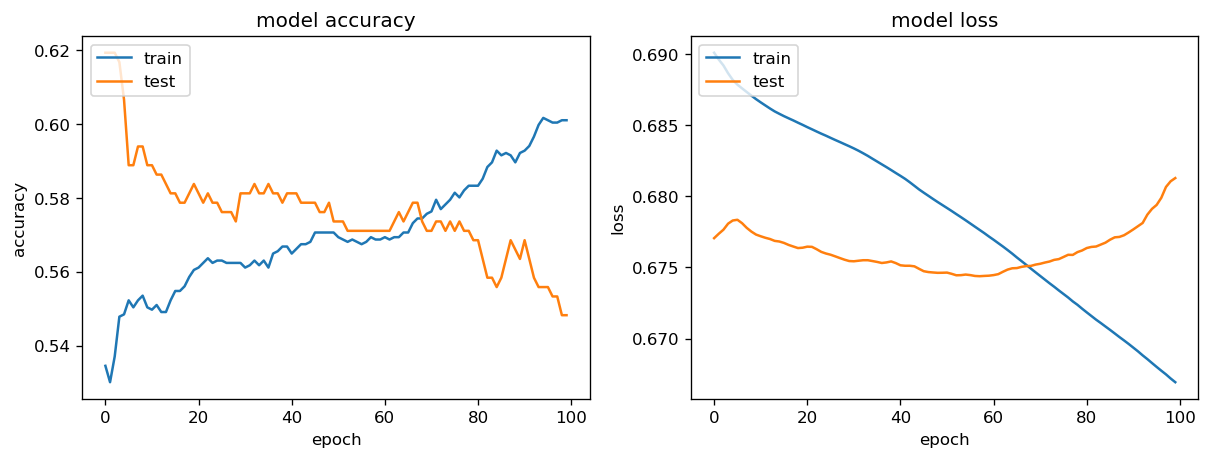

Training Score:
accuracy:	59.9746675262 %
loss: 		0.666593222961

Test Score:
accuracy:	54.8223350405 %
loss: 		0.681279586354


In [15]:
# DISPLAY RESULTS FOR MODEL_1
display_training_history(history_1)
display_results(model_1, trainX, trainY, testX, testY)

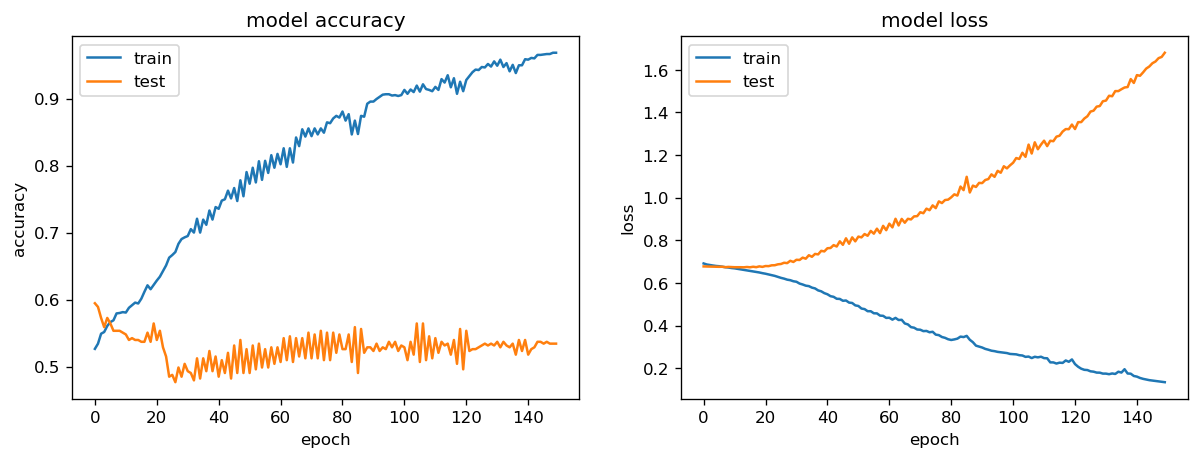

Training Score:
accuracy:	97.0967741935 %
loss: 		0.132741090588

Test Score:
accuracy:	53.4246576159 %
loss: 		1.68013647452


In [16]:
# DISPLAY RESULTS FOR MODEL_2
display_training_history(history_2)
display_results(model_2, trainXX, trainYY, testXX, testYY)

todos:
 - calc 4 results criteria; false negatives etc.
 - create more testing sets; bear market data, middle slice
 - compare performance of different look-back periods
 - Iterate through 100s of different hyperparams
 
 
 - look into using LTSM/RNN 
 - perhaps create visualisation of weights over time (probably not)


 - look at improving performance: good starting point: https://machinelearningmastery.com/improve-deep-learning-performance/